In [11]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/rangamati_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

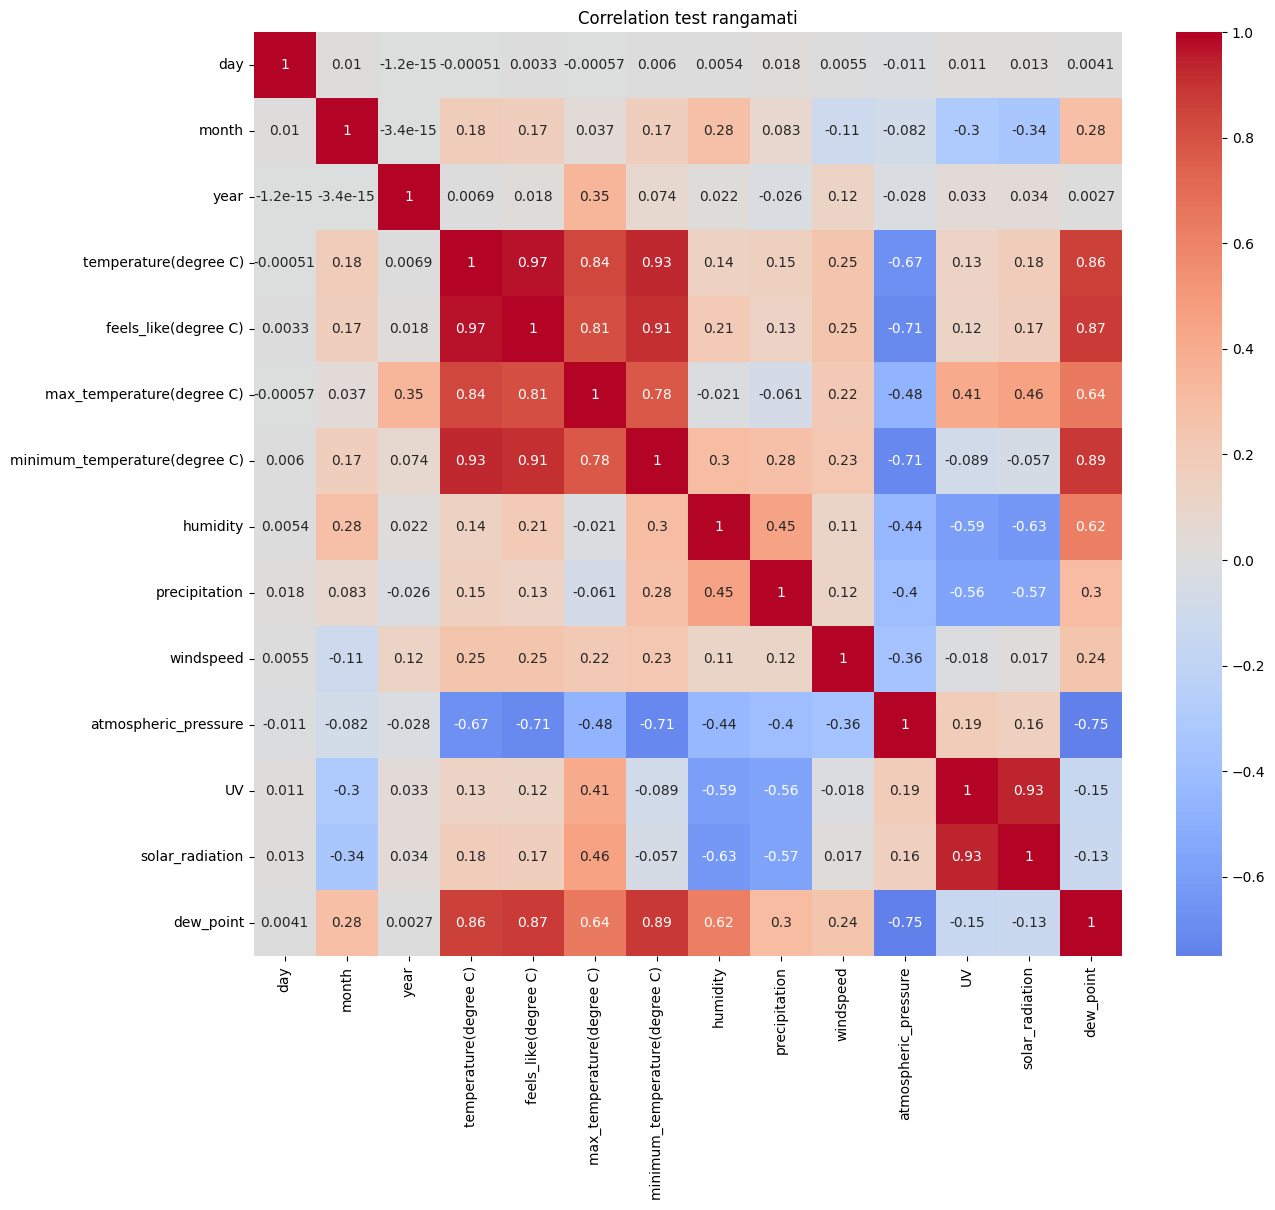

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation test rangamati')
plt.show()

# temperature

## rf

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [14]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for temperature:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []
all_importances = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    all_importances.append(rf_model_kf.feature_importances_)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Average_Importance', ascending=False)


diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nRandom Forest Feature Importances (Averaged over all folds):")
print(feature_importance_df_rf)




Random Forest Results for temperature:
MSE: 2.4174
RMSE: 1.5548
R² Score: 0.8121
Average RMSE from CV: 1.4494
Average R² from CV: 0.8320
Avarage MSE: 2.1121084519309776
Individual Fold RMSEs: [np.float64(1.5199274645627243), np.float64(1.399505663483012), np.float64(1.4572295919801994), np.float64(1.278527039240884), np.float64(1.5917277362001803)]

 R2 ~ -1.9875

Random Forest Feature Importances (Averaged over all folds):
              Feature  Average_Importance   Std_Dev
6           dew_lag_7            0.139088  0.017499
15         dew_roll_7            0.131526  0.015348
9           dew_lag_8            0.123334  0.002043
17       feels_roll_7            0.112570  0.024957
12          dew_lag_9            0.089674  0.006679
16         atm_roll_7            0.061646  0.004472
1   day_of_year_cos_1            0.060958  0.002425
7           atm_lag_7            0.047659  0.001081
4   day_of_year_sin_3            0.036307  0.004444
0   day_of_year_sin_1            0.030254  0.004198

## rf-lstm

In [16]:
FEATURES = fourier_cols + lag_cols + rolling_cols

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Windowed UV R2: 0.8184
Windowed UV MSE: 2.3448
Windowed UV RMSE: 1.5313


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = [
#     'minimum_temperature(degree C)',
#     'temp_lag_1',
#     'temp_roll_7', # 
#     'temp_lag_2', # 
#     'temp_lag_3', # 
#     'atm_roll_7', # 
#     'atm_lag_2', # ~ 1.84 r2
#     'atmospheric_pressure', # r2 -> ~ 1.15
#     'atm_lag_1', # 89.78/90.78 ~ -1
#     'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
#     'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
#     # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
#     # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20
# ]

lstm_feature_cols = FEATURES

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
--- HYBRID MODEL PERFORMANCE ---
Final temperature R2: 0.8123
Final temperature MSE: 2.4256
Final temperature RMSE: 2.4256


In [19]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

TEMP = 'temperature(degree C)'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'minimum_temperature(degree C)',
    # 'temp_lag_1',
    # 'temp_roll_7', # 
    # 'temp_lag_2', # 
    # 'temp_lag_3', # 
    # 'atm_roll_7', # 
    # 'atm_lag_2', # ~ 1.84 r2
    # 'atmospheric_pressure', # r2 -> ~ 1.15
    # 'atm_lag_1', # 89.78/90.78 ~ -1
    # 'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    # 'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # ]

    lstm_feature_cols = FEATURES

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 1 R2: 0.8155
Fold 1 MSE: 2.3559
Fold 1 RMSE: 1.5349
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 2 R2: 0.8455
Fold 2 MSE: 1.9911
Fold 2 RMSE: 1.4111
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 3 R2: 0.8526
Fold 3 MSE: 2.1333
Fold 3 RMSE: 1.4606
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 4 R2: 0.8688
Fold 4 MSE: 1.6531
Fold 4 RMSE: 1.2857
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Fold 5 R2: 0.7761
Fold 5 MSE: 2.4831
Fold 5 RMSE: 1.5758

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.8317 (+/- 0.0327)
Mean mse: 2.1233 (+/- 0.2906)
Mean rmse: 1.4536 (+/- 0.1016)


## xgboost

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [21]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''

'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for temperature:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)

        all_importances.append(xgb_model_kf.feature_importances_)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_xgb = feature_importance_df_rf.sort_values(by='Average_Importance', ascending=False)


diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for temperature:
Mean Squared Error: 2.7128
RMSE: 1.6471
R² Score: 0.7892


Average RMSE from CV: 1.5624
Average R² from CV: 0.8051
Avarage MSE: 2.901429029369244
Individual Fold RMSEs: [np.float64(1.6231046138468768), np.float64(1.5186898576873238), np.float64(1.56899570123096), np.float64(1.3976231577389444), np.float64(1.7033581623866556)]

 R2 ~ -1.5929

XGBoost Feature Importances:
              Feature  Average_Importance   Std_Dev
15         dew_roll_7            0.241576  0.172914
6           dew_lag_7            0.175997  0.138599
1   day_of_year_cos_1            0.127924  0.077546
17       feels_roll_7            0.097327  0.094613
9           dew_lag_8            0.066001  0.057447
12          dew_lag_9            0.047738  0.042212
4   day_of_year_sin_3            0.041414  0.014472
16         atm_roll_7            0.037453  0.024404
7           atm_lag_7            0.030723  0.018316
0   day_of_year_sin_1            0.023481  0.007975
10          atm_lag_8

## light gbm

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [24]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [25]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''



'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for temp:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        all_importances.append(lgb_model_kf.feature_importances_)


        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_lgb = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Average_Importance', ascending=False)


diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)


LightGBM Results for temp:
Mean Squared Error: 2.4582
RMSE: 1.5679
R² Score: 0.8090


Average RMSE from CV: 1.4784
Average R² from CV: 0.8253
Avarage MSE: 2.5584164987122384
Individual Fold RMSEs: [np.float64(1.5932065238989193), np.float64(1.411102471157335), np.float64(1.4716214068330429), np.float64(1.3166252942930632), np.float64(1.599505079301794)]

 R2 ~ -1.6347

LightGBM Feature Importances:
              Feature  Average_Importance     Std_Dev
15         dew_roll_7          131.627718  188.773770
16         atm_roll_7          128.758302  190.546322
1   day_of_year_cos_1          124.685283  177.380744
17       feels_roll_7          120.064885  173.789247
4   day_of_year_sin_3           93.360943  132.695148
2   day_of_year_sin_2           79.608562  116.538736
0   day_of_year_sin_1           77.482321  111.343120
7           atm_lag_7           76.753815  115.172853
5   day_of_year_cos_3           63.338843   93.256944
6           dew_lag_7           56.383998   83.898023
10 

## catboost

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [27]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [28]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''

'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temp :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)


        all_importances.append(cat_model_kf.feature_importances_)



        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# 3. Calculate the average across all folds
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0) # Bonus: see how stable they are!

# 4. Create the final DataFrame
feature_importance_df_cat = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
})

# 5. Sort by the average
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Average_Importance', ascending=False)


diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for temp :
Mean Squared Error: 2.3713
RMSE: 1.5399
R² Score: 0.8157


Average RMSE from CV: 1.4452
Average R² from CV: 0.8338
Avarage MSE: 2.0948205415009853
Individual Fold RMSEs: [np.float64(1.4872358047262864), np.float64(1.4214133863393712), np.float64(1.4672601957908609), np.float64(1.3088764155362729), np.float64(1.5413651094017287)]

 R2 ~ -1.8090

CatBoost Feature Importances:
              Feature  Average_Importance     Std_Dev
15         dew_roll_7          101.610638  171.557604
16         atm_roll_7           97.726938  173.551456
1   day_of_year_cos_1           97.300296  160.775941
17       feels_roll_7           92.260902  158.024262
4   day_of_year_sin_3           72.325563  120.555403
2   day_of_year_sin_2           61.213099  105.837069
0   day_of_year_sin_1           59.158071  101.515884
7           atm_lag_7           58.683140  104.538285
5   day_of_year_cos_3           48.539805   84.733132
6           dew_lag_7           43.914395   75.801751


## gru

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [30]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [31]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for temperature :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

Epoch 1/100


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.3867 - val_loss: 0.1362
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1639 - val_loss: 0.1310
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1550 - val_loss: 0.1284
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1526 - val_loss: 0.1258
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1482 - val_loss: 0.1265
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1489 - val_loss: 0.1278
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1436 - val_loss: 0.1246
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1447 - val_loss: 0.1219
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1418 - val_loss: 0.1278
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1419 - val_loss: 0.1254
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1400 - val_loss: 0.1245
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1397 - val_l

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


Average RMSE from CV: 1.4325
Average R² from CV: 0.8368
Average MSE: 2.0572
Individual Fold RMSEs: [np.float64(1.42826659968042), np.float64(1.419592437919243), np.float64(1.4597904115422549), np.float64(1.317449886972985), np.float64(1.5375206712936729)]

 R2 ~ -1.3849


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

def calculate_permutation_importance_gru(model, X_val, y_val, scaler_y):
    """
    Calculates importance for 3D GRU inputs by shuffling the feature dimension.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_inv = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_inv, scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    num_features = X_val.shape[2] # Number of columns in X
    
    for i in range(num_features):
        # Work on a copy to avoid corrupting the original data
        X_permuted = X_val.copy()
        
        # Shuffle the i-th feature across all samples
        # Note: we shuffle the sample order for that specific feature
        shuffled_feature = X_permuted[:, :, i]
        np.random.shuffle(shuffled_feature)
        X_permuted[:, :, i] = shuffled_feature
        
        # Predict and calculate new error
        shuffled_preds = model.predict(X_permuted, verbose=0)
        shuffled_mse = mean_squared_error(y_val_inv, scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the delta in MSE
        importances.append(max(0, shuffled_mse - baseline_mse))
        
    return np.array(importances)

# --- Cross-Validation Loop ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []
all_fold_importances = [] # Store importances from each fold

for fold, (train_index, test_index) in enumerate(tscv.split(X_reshaped)):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild and train model for this fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Calculate Standard Metrics
    y_pred_kf_scaled = gru_kf.predict(X_test_kf, verbose=0)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

    # --- Permutation Importance for this fold ---
    print(f"Processing Fold {fold+1} Importance...")
    fold_importance = calculate_permutation_importance_gru(gru_kf, X_test_kf, y_test_kf, scaler_y)
    all_fold_importances.append(fold_importance)

# --- Aggregate Results ---
avg_importance = np.mean(all_fold_importances, axis=0)
std_importance = np.std(all_fold_importances, axis=0)

# Create Final Importance DataFrame
# Assuming 'X' is your original dataframe to get feature names
feature_importance_gru = pd.DataFrame({
    'Feature': X.columns,
    'Average_Importance': avg_importance,
    'Std_Dev': std_importance
}).sort_values(by='Average_Importance', ascending=False)

# Final Reporting
print("\n--- GRU Final Results ---")
print(f"Average RMSE from CV: {np.mean(rmse_list_gru):.4f}")
print(f"Average R² from CV: {np.mean(r2_list_gru):.4f}")
print("\nGRU Permutation Feature Importances (Averaged):")
print(feature_importance_gru)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 1 Importance...


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 2 Importance...


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 3 Importance...


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 4 Importance...


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 5 Importance...

--- GRU Final Results ---
Average RMSE from CV: 1.3919
Average R² from CV: 0.8454

GRU Permutation Feature Importances (Averaged):
              Feature  Average_Importance   Std_Dev
1   day_of_year_cos_1            1.995657  0.668408
2   day_of_year_sin_2            0.538082  0.098331
3   day_of_year_cos_2            0.509625  0.161083
17       feels_roll_7            0.488409  0.240269
15         dew_roll_7            0.416014  0.175908
6           dew_lag_7            0.325443  0.243053
0   day_of_year_sin_1            0.269210  0.197416
4   day_of_year_sin_3            0.237347  0.060536
12          dew_lag_9            0.055666  0.066701
9           dew_lag_8            0.054594  0.017712
5   day_of_year_cos_3            0.043855  0.027588
11        feels_lag_8            0.034147  0.045955
8         feels_lag_7            0.027328  0.034850
7           atm_lag_7            0.023698  0.026201
16         atm_roll_7            0.023247  0.028804
14  

## lstm

In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [52]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [56]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

# --- 1. Scaling and Reshaping (Fix for image_d61d81.png) ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale 2D data first
X_scaled = scaler_X.fit_transform(X) 
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Now reshape to 3D for LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model


# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)



# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for temp :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')









# --- 2. Permutation Logic ---
def get_permutation_importance_fold(model, X_val, y_val, scaler_y):
    # Baseline
    baseline_preds = model.predict(X_val, verbose=0)
    # Fix for image_d6383f: Ensure scaler_y is used only after fit_transform is called
    y_val_unscaled = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds.reshape(-1, 1)))
    
    fold_imps = []
    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])
        
        perm_preds = model.predict(X_permuted, verbose=0)
        perm_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(perm_preds.reshape(-1, 1)))
        fold_imps.append(max(0, perm_mse - baseline_mse))
    return fold_imps

# --- 3. CV Loop (Fix for image_d462c2.png) ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm, r2_list_lstm, mse_list_lstm, all_fold_importances = [], [], [], []

print("Starting Cross-Validation...")

# Important: split on X_reshaped (the NumPy array) to avoid KeyErrors
for train_index, test_index in tscv.split(X_reshaped):
    # NumPy indexing works perfectly here
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Prediction and Evaluation
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf, verbose=0)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled.reshape(-1, 1))
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf.reshape(-1, 1))

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))
    
    fold_importance = get_permutation_importance_fold(lstm_kf, X_test_kf, y_test_kf, scaler_y)
    all_fold_importances.append(fold_importance)

# --- 4. Aggregates ---
lstm_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Average_Importance': np.mean(all_fold_importances, axis=0),
    'Std_Dev': np.std(all_fold_importances, axis=0)
}).sort_values(by='Average_Importance', ascending=False)

average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")


print("\nTop Importances:")
print(lstm_importance_df.head())

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

LSTM Results for temp :
Mean Squared Error: 2.1505
RMSE: 1.4665
R² Score: 0.8329
Starting Cross-Validation...


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 



Average RMSE from LSTM CV: 1.3813
Average R² from LSTM CV: 0.8477
Average MSE: 1.9139
Individual Fold RMSEs: [np.float64(1.3971867862808254), np.float64(1.38454562388002), np.float64(1.3511639878363688), np.float64(1.2678436083522127), np.float64(1.5056903242761934)]

Top Importances:
              Feature  Average_Importance   Std_Dev
1   day_of_year_cos_1            1.938777  0.466516
2   day_of_year_sin_2            0.651043  0.212669
17       feels_roll_7            0.424178  0.211152
3   day_of_year_cos_2            0.370866  0.171975
15         dew_roll_7            0.283405  0.105733


## ann

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]




In [39]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for temperature :
Mean Squared Error: 2.5204
RMSE: 1.5876
R² Score: 0.8041


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Average RMSE from ANN CV: 1.4696
Average R² from ANN CV: 0.8279
Average MSE: 2.1684
Individual Fold RMSEs: [np.float64(1.5033891005685789), np.float64(1.4655347864560653), np.float64(1.4900142521095), np.float64(1.3026727159796174), np.float64(1.586433733793008)]

 R2 ~ -2.3711

ANN Permutation Feature Importances:
              Feature  Importance
1   day_of_year_cos_1    2.293088
4   day_of_year_sin_3    0.810234
2   day_of_year_sin_2    0.564918
17       feels_roll_7    0.518938
0   day_of_year_sin_1    0.471498
6           dew_lag_7    0.295716
8         feels_lag_7    0.144814
16         atm_roll_7    0.141122
15         dew_roll_7    0.071813
3   day_of_year_cos_2    0.050110
10          atm_lag_8    0.043973
11        feels_lag_8    0.040876
14        feels_lag_9    0.040771
12          dew_lag_9    0.029527
9           dew_lag_8    0.000000
7           atm_lag_7    0.000000
5   day_of_year_cos_3    0.000000
13          atm_lag_9    0.000

## cnn-lstm

In [72]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point', 'atmospheric_pressure','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [7, 8, 9]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'feels_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)

    lag_cols.extend([f'dew_lag_{lag}', f'atm_lag_{lag}', f'feels_lag_{lag}'])

# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean().shift(7))
df['feels_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean().shift(7))


rolling_cols = ['dew_roll_7', 'atm_roll_7', 'feels_roll_7']

df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [73]:
FEATURES =  fourier_cols + lag_cols + rolling_cols 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['temperature(degree C)'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Base Results: R2: 0.8481, MSE: 1.9629, RMSE: 1.4010


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
5-Fold CV Average: R2: 0.8526, MSE: 1.8669, RMSE: 1.3315



In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
# from keras.optimizers import Adam

# # 1. DATA PREPARATION (Multivariate)
# window = 30
# # Combine all features and the target into one array
# data_all = df[FEATURES + ['temperature(degree C)']].values

# def create_sequences_multivariate(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         # All columns except the last one are features
#         X.append(data[i:(i + window_size), :-1]) 
#         # The last column is the target (temperature)
#         y.append(data[i + window_size, -1]) 
#     return np.array(X), np.array(y)

# X, y = create_sequences_multivariate(data_all, window)

# # Split into Train and Test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # 2. UPDATED HYBRID MODEL
# def build_hybrid_multivariate(input_shape):
#     model = Sequential([
#         # input_shape will be (30, 18)
#         Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.2),

#         LSTM(64, activation='tanh', return_sequences=False), 
#         Dropout(0.2),

#         Dense(32, activation='relu'),
#         Dropout(0.1),
#         Dense(1)
#     ])
    
#     optimizer = Adam(learning_rate=0.0005)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # Initialize and train
# model = build_hybrid_multivariate((window, len(FEATURES)))
# model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# # 3. PERMUTATION IMPORTANCE WITH STD DEV
# def get_permutation_importance(model, X_val, y_val, feature_names):
#     base_preds = model.predict(X_val, verbose=0)
#     base_rmse = np.sqrt(mean_squared_error(y_val, base_preds))
    
#     importance_results = []

#     for i, col_name in enumerate(feature_names):
#         scores = []
#         # Run 5 times to get Standard Deviation
#         for run in range(5):
#             X_shuffled = X_val.copy()
#             # Shuffle only the specific feature across all samples and time steps
#             # We shuffle the 'depth' slice corresponding to feature i
#             shuffled_feature = np.random.permutation(X_shuffled[:, :, i].flatten())
#             X_shuffled[:, :, i] = shuffled_feature.reshape(X_shuffled.shape[0], X_shuffled.shape[1])
            
#             shuff_preds = model.predict(X_shuffled, verbose=0)
#             shuff_rmse = np.sqrt(mean_squared_error(y_val, shuff_preds))
#             scores.append(shuff_rmse - base_rmse)
        
#         importance_results.append({
#             'Feature': col_name,
#             'Average_Importance': np.mean(scores),
#             'Std_Dev': np.std(scores)
#         })
#         print(f"Computed importance for: {col_name}")

#     return pd.DataFrame(importance_results).sort_values(by='Average_Importance', ascending=False)

# # Run the importance check
# importance_df_hybrid = get_permutation_importance(model, X_test, y_test, FEATURES)

# print("\n--- Hybrid Model Feature Importance (Averaged) ---")
# print(importance_df_hybrid)

Epoch 1/20


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 412.8776 - mae: 19.1372
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.8130 - mae: 3.3619
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.4228 - mae: 2.6872
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.2913 - mae: 2.5565
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.7541 - mae: 2.6100
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.1317 - mae: 2.5259
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2615 - mae: 2.4051
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1826 - mae: 2.3896
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8866 - mae: 2.4933
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6760 - mae: 2.4821
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7829 - mae: 2.3297
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3897 - mae: 2.4253
Epoch 13/20
101/101 ━━━━━━━━

In [85]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Added for normalization
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# 1. SCALING AND DATA PREPARATION
window = 30
# Initialize scalers for features (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features and target separately
scaled_features = scaler_X.fit_transform(df[FEATURES])
scaled_target = scaler_y.fit_transform(df[['temperature(degree C)']])

# Combine scaled data back for sequence creation
data_all_scaled = np.hstack((scaled_features, scaled_target))

def create_sequences_multivariate(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :-1]) 
        y.append(data[i + window_size, -1]) 
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(data_all_scaled, window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. UPDATED HYBRID MODEL (No changes needed to architecture)
def build_hybrid_multivariate(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_hybrid_multivariate((window, len(FEATURES)))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 3. PERFORMANCE EVALUATION (With Inverse Scaling)
y_pred_scaled = model.predict(X_test)
# Convert predictions and actuals back to original Celsius values
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse_final = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2_final = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"\nRescaled Results: R2: {r2_final:.4f}, RMSE: {np.sqrt(mse_final):.4f}")

# 4. PERMUTATION IMPORTANCE (Standard logic remains)
def get_permutation_importance(model, X_val, y_val, feature_names):
    base_preds = model.predict(X_val, verbose=0)
    base_rmse = np.sqrt(mean_squared_error(y_val, base_preds))
    importance_results = []

    for i, col_name in enumerate(feature_names):
        scores = []
        for run in range(5):
            X_shuffled = X_val.copy()
            shuffled_feature = np.random.permutation(X_shuffled[:, :, i].flatten())
            X_shuffled[:, :, i] = shuffled_feature.reshape(X_shuffled.shape[0], X_shuffled.shape[1])
            shuff_preds = model.predict(X_shuffled, verbose=0)
            shuff_rmse = np.sqrt(mean_squared_error(y_val, shuff_preds))
            scores.append(shuff_rmse - base_rmse)
        
        importance_results.append({
            'Feature': col_name,
            'Average_Importance': np.mean(scores),
            'Std_Dev': np.std(scores)
        })
        print(f"Computed importance for: {col_name}")

    return pd.DataFrame(importance_results).sort_values(by='Average_Importance', ascending=False)

importance_df_hybrid = get_permutation_importance(model, X_test, y_test, FEATURES)
print("\n--- Hybrid Model Feature Importance ---")
print(importance_df_hybrid)

Epoch 1/20


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2752 - mae: 0.4029
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1747 - mae: 0.3280
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1633 - mae: 0.3166
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1590 - mae: 0.3149
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1568 - mae: 0.3138
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1511 - mae: 0.3055
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1508 - mae: 0.3044
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1524 - mae: 0.3077
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1455 - mae: 0.3009
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1427 - mae: 0.2974
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1411 - mae: 0.2949
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1378 - mae: 0.2937
Epoch 13/20
101/101 ━━━━━━━━━━━━━━━━

In [87]:
import pandas as pd
import numpy as np

def predict_next_7_days_scaled(model, df, features, scaler_X, scaler_y, window_size=30):
    # 1. Get the last window of data and scale it
    # We use the already fitted scaler_X
    last_raw_data = df[features].tail(window_size).values
    current_batch = scaler_X.transform(last_raw_data) 
    current_batch = current_batch.reshape((1, window_size, len(features)))
    
    future_predictions_scaled = []
    
    # 2. Recursive Prediction Loop
    for i in range(7):
        # Predict (this gives the negative/scaled number)
        next_pred_scaled = model.predict(current_batch, verbose=0)[0, 0]
        future_predictions_scaled.append(next_pred_scaled)
        
        # 3. Update the window
        # Create a new row for the next step
        # Note: For a true forecast, we'd need to update lags/fourier manually.
        # For this block, we shift the window and carry over the last feature state.
        new_row = current_batch[:, -1:, :].copy()
        
        # Shift: Remove oldest day, append the newest "predicted" state
        next_step = np.append(current_batch[:, 1:, :], new_row, axis=1)
        current_batch = next_step

    # 4. INVERSE TRANSFORM: The magic step that fixes the "lol" values
    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
    final_temperatures = scaler_y.inverse_transform(future_predictions_scaled)
    
    # 5. Create the DataFrame
    last_date = pd.to_datetime(df['date']).max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)
    
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Predicted_Temperature(C)': final_temperatures.flatten()
    })
    
    return forecast_df

# --- EXECUTION ---
# Make sure model, scaler_X, and scaler_y are defined from your previous part 2 block
forecast_results = predict_next_7_days_scaled(model, df, FEATURES, scaler_X, scaler_y)

print("\n--- Final Corrected Temperature Forecast ---")
print(forecast_results)

c:\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



--- Final Corrected Temperature Forecast ---
        Date  Predicted_Temperature(C)
0 2025-01-01                 20.271872
1 2025-01-02                 20.181131
2 2025-01-03                 19.993156
3 2025-01-04                 19.984350
4 2025-01-05                 19.898813
5 2025-01-06                 19.933506
6 2025-01-07                 19.877831


## model chart temperature

In [88]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF       MSE    MSE CV  \
7              ANN  0.804140  0.827850 -0.023711  2.520402  2.168368   
0    Random Forest  0.812143  0.832019 -0.019875  2.417412  2.112108   
1   RF-LSTM hybrid  0.812293  0.831710 -0.019417  2.425597  2.123299   
4         CatBoost  0.815728  0.833819 -0.018090  2.371275  2.094821   
3         LightGBM  0.808973  0.825320 -0.016347  2.458200  2.558416   
2          XGBoost  0.789186  0.805115 -0.015929  2.712832  2.901429   
6             LSTM  0.832884  0.847671 -0.014787  2.150510  1.913854   
5              GRU  0.822915  0.836764 -0.013849  2.278793  2.057164   
8  CNN-LSTM hybrid  0.848097  0.852579 -0.004482  1.962856  1.866950   

       RMSE   RMSE CV  
7  1.587577  1.469609  
0  1.554803  1.449383  
1  1.557433  1.453610  
4  1.539894  1.445230  
3  1.567865  1.478412  
2  1.647068  1.562354  
6  1.466462  1.381286  
5  1.509567  1.432524  
8  1.401020  1.331463  


## best model temp

In [89]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

The Best Logical Model is: CNN-LSTM hybrid
--- Reason: Balanced score across R^2 (0.8481) and Stability (DIFF: -0.0045)


# humidity

## rf

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''

Random Forest Feature Importances (from last fold):
                 Feature  Importance
0              dew_point    0.155580
1        solar_radiation    0.088104
4          precipitation    0.084600
11             dew_lag_1    0.065182
30            ppt_roll_7    0.055049
15             ppt_lag_1    0.048433
26            dew_roll_7    0.047487
16             dew_lag_2    0.040781
2                     UV    0.039974
12           solar_lag_1    0.037012
27          solar_roll_7    0.032418
5      day_of_year_sin_1    0.028574
21             dew_lag_3    0.026609
20             ppt_lag_2    0.026108
28             UV_roll_7    0.021216
29            atm_roll_7    0.018632
7      day_of_year_sin_2    0.018497
17           solar_lag_2    0.017153
6      day_of_year_cos_1    0.015178
8      day_of_year_cos_2    0.014425
14             atm_lag_1    0.014328
24             atm_lag_3    0.014084
22           solar_lag_3    0.012545
19             atm_lag_2    0.012431
3   atmospheric_pressure    0.012420
25             ppt_lag_3    0.011639
10     day_of_year_cos_3    0.011397
13              UV_lag_1    0.011191
9      day_of_year_sin_3    0.010764
18              UV_lag_2    0.004636
23              UV_lag_3    0.003553


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for humidity:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for humidity:
MSE: 17.6048
RMSE: 4.1958
R² Score: 0.7716
Average RMSE from CV: 3.9422
Average R² from CV: 0.7368
Avarage MSE: 15.567957596248636
Individual Fold RMSEs: [np.float64(3.9100238467696924), np.float64(3.6954557848454552), np.float64(4.120366111523905), np.float64(3.8540159460006147), np.float64(4.130890005333734)]

 R2 ~ 3.4786

Random Forest Feature Importances (from last fold):
                 Feature  Importance
0              dew_point    0.139534
1        solar_radiation    0.106911
4          precipitation    0.079877
11             dew_lag_1    0.058772
30            ppt_roll_7    0.056817
26            dew_roll_7    0.049323
2                     UV    0.046780
5      day_of_year_sin_1    0.044348
12           solar_lag_1    0.040384
16             dew_lag_2    0.038196
15             ppt_lag_1    0.038183
27          solar_roll_7    0.033335
28             UV_roll_7    0.024678
21             dew_lag_3    0.023345
17           solar_lag_2    

## rf-lstm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Windowed UV R2: 0.7731
Windowed UV MSE: 17.5869
Windowed UV RMSE: 4.1937


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = [
#     'dew_point', 
#     'solar_radiation', 
#     'precipitation', 
#     'dew_lag_1', 
#     'ppt_roll_7', 
#     'ppt_lag_1', 
#     'dew_roll_7', # 77.89/76.19 *1.69
#     'dew_lag_2', # 77.15/75.79 *1.35
#     'UV', # 77.94/76.95 *0.99
#     'solar_lag_1',  # 78.25/77.45 *0.80 [better]
#     # 'solar_roll_7', # 78.93/77.67 *1.25
#     # 'day_of_year_sin_1', # 79.27/77.84 *1.43
#     # 'dew_lag_3', 
#     # 'ppt_lag_2', 
#     # 'UV_roll_7', # 78.35/76.86 *1.48
# ]

lstm_feature_cols = FEATURES # change korai lagbe eita naile noise add hobe (therory)

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final humidity R2: {rf_lstm_r2:.4f}")
print(f"Final humidity MSE: {rf_lstm_mse:.4f}")
print(f"Final humidity RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
--- HYBRID MODEL PERFORMANCE ---
Final humidity R2: 0.7616
Final humidity MSE: 18.4334
Final humidity RMSE: 18.4334


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

HUM = 'humidity'
X_full = df[FEATURES]
y_full = df[HUM]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'dew_point', 
    #     'solar_radiation', 
    #     'precipitation', 
    #     'dew_lag_1', 
    #     'ppt_roll_7', 
    #     'ppt_lag_1', 
    #     'dew_roll_7', # 77.89/76.19 *1.69
    #     'dew_lag_2', # 77.15/75.79 *1.35
    #     'UV', # 77.94/76.95 *0.99
    #     'solar_lag_1',  # 78.25/77.45 *0.80 [better]
    #     # 'solar_roll_7', # 78.93/77.67 *1.25
    #     # 'day_of_year_sin_1', # 79.27/77.84 *1.43
    #     # 'dew_lag_3', 
    #     # 'ppt_lag_2', 
    #     # 'UV_roll_7', # 78.35/76.86 *1.48
    # ]

    lstm_feature_cols = FEATURES # change korai lagbe eita naile noise add hobe (therory)

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 1 R2: 0.6734
Fold 1 MSE: 15.5546
Fold 1 RMSE: 3.9439
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Fold 2 R2: 0.7190
Fold 2 MSE: 13.7796
Fold 2 RMSE: 3.7121
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Fold 3 R2: 0.7663
Fold 3 MSE: 17.1275
Fold 3 RMSE: 4.1385
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Fold 4 R2: 0.7220
Fold 4 MSE: 15.5395
Fold 4 RMSE: 3.9420
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 5 R2: 0.7730
Fold 5 MSE: 17.4868
Fold 5 RMSE: 4.1817

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.7308 (+/- 0.0362)
Mean mse: 15.8976 (+/- 1.3244)
Mean rmse: 3.9837 (+/- 0.1675)


## xgboost

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for humidity:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for humidity:
Mean Squared Error: 14.7310
RMSE: 3.8381
R² Score: 0.8089


Average RMSE from CV: 3.6828
Average R² from CV: 0.7702
Avarage MSE: 14.612359371665688
Individual Fold RMSEs: [np.float64(3.65970683129096), np.float64(3.4010821617132763), np.float64(3.8579947932262537), np.float64(3.672821170645639), np.float64(3.8226115904791698)]

 R2 ~ 3.8723

XGBoost Feature Importances:
                 Feature  Importance
4          precipitation    0.403497
5      day_of_year_sin_1    0.100931
1        solar_radiation    0.100618
0              dew_point    0.094867
27          solar_roll_7    0.041627
28             UV_roll_7    0.035498
6      day_of_year_cos_1    0.018306
15             ppt_lag_1    0.017963
12           solar_lag_1    0.013278
30            ppt_roll_7    0.013124
7      day_of_year_sin_2    0.012235
26            dew_roll_7    0.010923
10     day_of_year_cos_3    0.010783
16             dew_lag_2    0.010388
29            atm_roll_7    0.010151
9   

## light gbm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                 Feature  Importance
0              dew_point         887
1        solar_radiation         395
11             dew_lag_1         242
26            dew_roll_7         232
12           solar_lag_1         199
29            atm_roll_7         197
27          solar_roll_7         193
3   atmospheric_pressure         177
9      day_of_year_sin_3         177
7      day_of_year_sin_2         174
30            ppt_roll_7         159
16             dew_lag_2         158
5      day_of_year_sin_1         157
17           solar_lag_2         148
4          precipitation         139
19             atm_lag_2         134
14             atm_lag_1         130
24             atm_lag_3         122
6      day_of_year_cos_1         118
10     day_of_year_cos_3         116
21             dew_lag_3         113
28             UV_roll_7          83
22           solar_lag_3          78
8      day_of_year_cos_2          76
15             ppt_lag_1          66
20             ppt_lag_2          48
25             ppt_lag_3          36
2                     UV          29
13              UV_lag_1          27
23              UV_lag_3          11
18              UV_lag_2           6

'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for humidity:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)




LightGBM Results for humidity:
Mean Squared Error: 14.1277
RMSE: 3.7587
R² Score: 0.8167


Average RMSE from CV: 3.5802
Average R² from CV: 0.7830
Avarage MSE: 14.134213779600852
Individual Fold RMSEs: [np.float64(3.5509844660036096), np.float64(3.2917068291552996), np.float64(3.7279916935743342), np.float64(3.570812229007886), np.float64(3.7595496777673856)]

 R2 ~ 3.3691

LightGBM Feature Importances:
                 Feature  Importance
0              dew_point         879
1        solar_radiation         408
26            dew_roll_7         278
27          solar_roll_7         222
11             dew_lag_1         210
29            atm_roll_7         199
7      day_of_year_sin_2         186
16             dew_lag_2         173
9      day_of_year_sin_3         168
12           solar_lag_1         167
5      day_of_year_sin_1         145
30            ppt_roll_7         144
4          precipitation         139
3   atmospheric_pressure         135
22           solar_lag_3         127


## catboost

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''


'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temperature :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for temperature :
Mean Squared Error: 13.3509
RMSE: 3.6539
R² Score: 0.8268


Average RMSE from CV: 3.5037
Average R² from CV: 0.7921
Avarage MSE: 12.299904257514788
Individual Fold RMSEs: [np.float64(3.4890888236700617), np.float64(3.2479146594437798), np.float64(3.658303839944282), np.float64(3.455011589780077), np.float64(3.668315521083086)]

 R2 ~ 3.4718

CatBoost Feature Importances:
                 Feature  Importance
0              dew_point   34.957479
1        solar_radiation   15.807716
2                     UV    5.092138
4          precipitation    4.867053
5      day_of_year_sin_1    4.284011
12           solar_lag_1    3.947512
27          solar_roll_7    3.277144
11             dew_lag_1    3.030873
7      day_of_year_sin_2    2.147382
30            ppt_roll_7    1.917301
28             UV_roll_7    1.844531
22           solar_lag_3    1.822347
9      day_of_year_sin_3    1.748943
16             dew_lag_2    1.491004
26            dew_roll_7    1.48713

## gru

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for humidity :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

Epoch 1/100


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.4578 - val_loss: 0.3905
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2997 - val_loss: 0.3181
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2562 - val_loss: 0.2718
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2192 - val_loss: 0.2498
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2088 - val_loss: 0.2429
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1972 - val_loss: 0.2195
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1874 - val_loss: 0.2168
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1781 - val_loss: 0.2238
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1745 - val_loss: 0.2105
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1742 - val_loss: 0.2020
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1692 - val_loss: 0.1997
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1661 - val_l

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


Average RMSE from CV: 3.4535
Average R² from CV: 0.7954
Average MSE: 11.9556
Individual Fold RMSEs: [np.float64(3.6869101130078934), np.float64(3.1710133279400674), np.float64(3.4466927430790193), np.float64(3.4123048661716826), np.float64(3.5504774294230876)]

 R2 ~ 3.9907


In [ ]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)


GRU Permutation Feature Importances:
                 Feature  Importance
0              dew_point  121.367800
1        solar_radiation   10.821812
27          solar_roll_7    7.912537
6      day_of_year_cos_1    5.638081
4          precipitation    5.015765
22           solar_lag_3    3.303971
11             dew_lag_1    2.717089
7      day_of_year_sin_2    2.295178
8      day_of_year_cos_2    2.278770
12           solar_lag_1    1.927585
3   atmospheric_pressure    1.848802
9      day_of_year_sin_3    1.710708
30            ppt_roll_7    1.350056
17           solar_lag_2    1.207883
28             UV_roll_7    1.098977
2                     UV    0.704078
15             ppt_lag_1    0.656112
19             atm_lag_2    0.529841
10     day_of_year_cos_3    0.441217
16             dew_lag_2    0.423045
13              UV_lag_1    0.417748
14             atm_lag_1    0.354113
24             atm_lag_3    0.304154
29            atm_roll_7    0.153995
26            dew_roll_7    0.123754


## lstm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for humidity :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

LSTM Results for humidity :
Mean Squared Error: 12.6835
RMSE: 3.5614
R² Score: 0.8354


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Average RMSE from LSTM CV: 3.4752
Average R² from LSTM CV: 0.7943
Average MSE: 12.1037
Individual Fold RMSEs: [np.float64(3.6140988613254064), np.float64(3.2050387313387008), np.float64(3.5441046912255816), np.float64(3.371588340405188), np.float64(3.6409248175160127)]

 R2 ~ 4.1173

LSTM Permutation Feature Importances:
                 Feature  Importance
0              dew_point  157.948376
1        solar_radiation   11.156641
6      day_of_year_cos_1    9.020735
27          solar_roll_7    6.476281
4          precipitation    3.563526
12           solar_lag_1    1.989953
8      day_of_year_cos_2    1.799910
30            ppt_roll_7    1.731817
28             UV_roll_7    1.661846
9      day_of_year_sin_3    1.514726
7      day_of_year_sin_2    1.374762
2                     UV    1.210758
17           solar_lag_2    0.935181
13              UV_lag_1    0.876825
26            dew_roll_7    0.809520
22           solar_lag_3    0.799450
11    

## ann

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for humidity :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for humidity :
Mean Squared Error: 15.3567
RMSE: 3.9188
R² Score: 0.8008


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Average RMSE from ANN CV: 3.5230
Average R² from ANN CV: 0.7884
Average MSE: 12.4268
Individual Fold RMSEs: [np.float64(3.592629131994258), np.float64(3.2800550734862766), np.float64(3.6116741795835314), np.float64(3.5306445166978064), np.float64(3.5997946180526945)]

 R2 ~ 1.2351

ANN Permutation Feature Importances:
                 Feature  Importance
0              dew_point  173.859417
6      day_of_year_cos_1   26.116899
1        solar_radiation   14.223233
27          solar_roll_7    8.528900
11             dew_lag_1    5.512401
28             UV_roll_7    3.692933
26            dew_roll_7    2.197311
9      day_of_year_sin_3    2.136673
12           solar_lag_1    2.078007
7      day_of_year_sin_2    1.806840
4          precipitation    1.785527
30            ppt_roll_7    1.635173
13              UV_lag_1    1.465332
16             dew_lag_2    1.403581
8      day_of_year_cos_2    1.309847
18              UV_lag_2    1.079728
10     day

## cnn-lstm

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 77.20/75.46 *7.74

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['humidity'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['humidity'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Base Results: R2: 0.6653, MSE: 25.9356, RMSE: 5.0927


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
5-Fold CV Average: R2: 0.1957, MSE: 51.4303, RMSE: 7.0213



## model chart humidity

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF        MSE     MSE CV  \
7              ANN  0.800765  0.788415  0.012351  15.356662  12.426782   
1   RF-LSTM hybrid  0.761638  0.730757  0.030881  18.433387  15.897598   
3         LightGBM  0.816710  0.783018  0.033691  14.127708  14.134214   
4         CatBoost  0.826788  0.792069  0.034718  13.350915  12.299904   
0    Random Forest  0.771598  0.736812  0.034786  17.604841  15.567958   
2          XGBoost  0.808883  0.770160  0.038723  14.730972  14.612359   
5              GRU  0.835348  0.795441  0.039907  12.691112  11.955607   
6             LSTM  0.835446  0.794273  0.041173  12.683530  12.103721   
8  CNN-LSTM hybrid  0.665312  0.195742  0.469570  25.935557  51.430318   

       RMSE   RMSE CV  
7  3.918758  3.522960  
1  4.293412  3.983659  
3  3.758684  3.580209  
4  3.653890  3.503727  
0  4.195812  3.942150  
2  3.838095  3.682843  
5  3.562459  3.453480  
6  3.561394  3.475151  
8  5.092696  7.021294  


## best model humidty

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

The Best Logical Model is: LSTM
--- Reason: Balanced score across R^2 (0.8354) and Stability (DIFF: 0.0412)


# dewpoint

## rf

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


## rf-lstm

## xgboost

## light gbm

## catboost

## gru

## lstm

## ann

## cnn-lstm

## model chart dew point

## best model dewpoint

# solar radiation

## rf

## rf-lstm

## xgboost

## light gbm

## catboost

## gru

## lstm

## ann

## cnn-lstm

## model chart solar

## best model solar